https://academic.oup.com/bioinformatics/article/36/4/1234/5566506?login=false

https://huggingface.co/dmis-lab/biobert-large-cased-v1.1-squad

https://github.com/dmis-lab/biobert

https://github.com/dmis-lab/biobert-pytorch/tree/master/embedding

https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/



In [2]:
import torch
from torchtext import data
from transformers import BertTokenizer, BertModel

# Load the pre-trained BioBERT model and tokenizer
model = BertModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1 were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
samples_with_synonyms = ['Myocardial infarction', 
'Cardiac infarction',
'Heart attack',
'Myocardial infarct',
'Myocardial infarction (disorder)',
'Infarction of heart',
'MI - myocardial infarction',
'Headache', 
'Cephalodynia',
'Cephalalgia',
'Headache (finding)',
'Head pain',
'Pain in head',
'HA - Headache',
'Cephalgia',
'Stomach cramps',
'Stomach gripes',
'Bacterial sepsis',
'Bacterial septicemia',
'Bacterial sepsis (disorder)',
'Bacterial septicaemia'
]

In [50]:
# Split the sentence into tokens.
encoded_sentences  = [tokenizer.encode(sentence, add_special_tokens=True) for sentence in samples_with_synonyms]

In [51]:
max_length = max([len(sentence) for sentence in encoded_sentences])

In [52]:
# Add padding to max length of the sentence (All sentences must be padded or truncated to a single, fixed length.)
padded_sentences = [sentence + [0] * (max_length - len(sentence)) for sentence in encoded_sentences]

In [53]:
input_ids = torch.tensor(padded_sentences)

In [54]:
#The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicates a value that should be attended to, while 0 indicates a padded value.
attention_mask = torch.where(input_ids != 0, torch.ones_like(input_ids), torch.zeros_like(input_ids))

In [55]:
# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [56]:
# Get the BIOBERT embeddings for the sentences (Side note: torch.no_grad tells PyTorch not to construct the compute graph during this forward pass (since we won’t be running backprop here)–this just reduces memory consumption and speeds things up a little.)
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

In [57]:
#Last headen state
outputs[1].shape

torch.Size([21, 768])

In [58]:
import numpy as np
# Convert the pooled_output tensor to a numpy array
sentence_vectors = np.array(outputs[1].detach().numpy())

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between the sentence vectors
similarities = cosine_similarity(sentence_vectors)

# Get the indices of the top 3 most similar sentences
top_3_indices = similarities[0].argsort()[-4:-1][::-1]

# Print the sentences
print('For the ', samples_with_synonyms[0], ' the top 3 similar sentences will be:')
for i in top_3_indices:
    print(samples_with_synonyms[i])

For the  Myocardial infarction  the top 3 similar sentences will be:
Head pain
MI - myocardial infarction
Myocardial infarction (disorder)


In [81]:
top_3_indices

array([11,  6,  4])

Хрень немножко

In [63]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


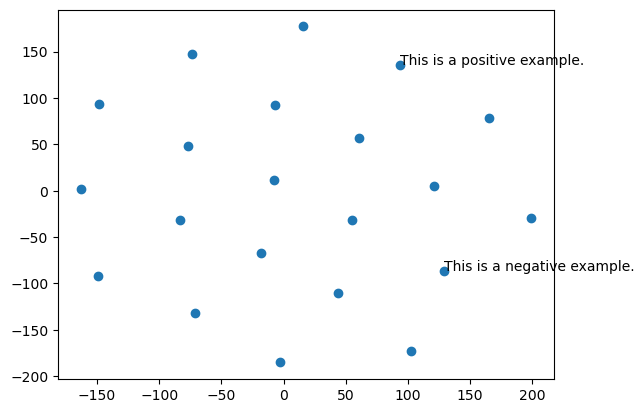

In [64]:
# Perform T-SNE on the sentence vectors
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=0)
sentence_vectors_tsne = tsne.fit_transform(sentence_vectors)

# Plot the T-SNE visualization
plt.scatter(sentence_vectors_tsne[:, 0], sentence_vectors_tsne[:, 1])
for i, sentence in enumerate(sentences):
    plt.annotate(sentence, (sentence_vectors_tsne[i, 0], sentence_vectors_tsne[i, 1]))
plt.show()